## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json
import mvranalysis as mvr

## Setup plotting

In [2]:
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

In [1173]:
path = '/Volumes/freeman/Nick/mVR/sessions/000090'
session = mvr.load_session(path)


In [1174]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceRcts.mat


In [1175]:
#session.to_csv(path + '/behavior/session.csv')

#### Create trial summary

In [1176]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [1177]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep

## Plot data

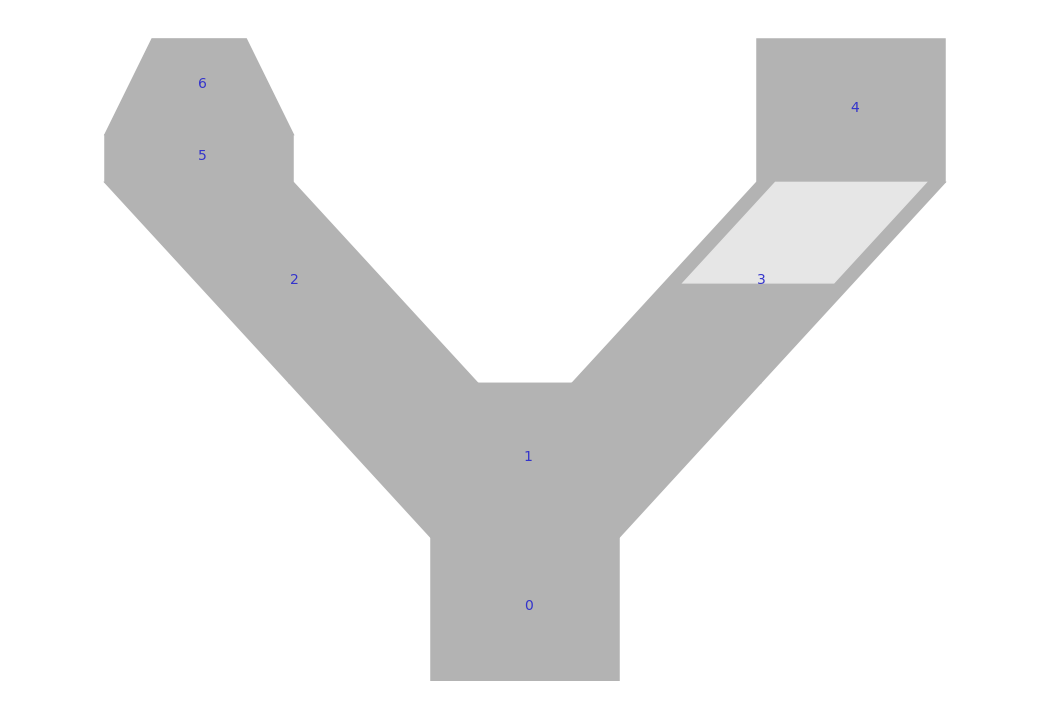

In [1178]:
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)

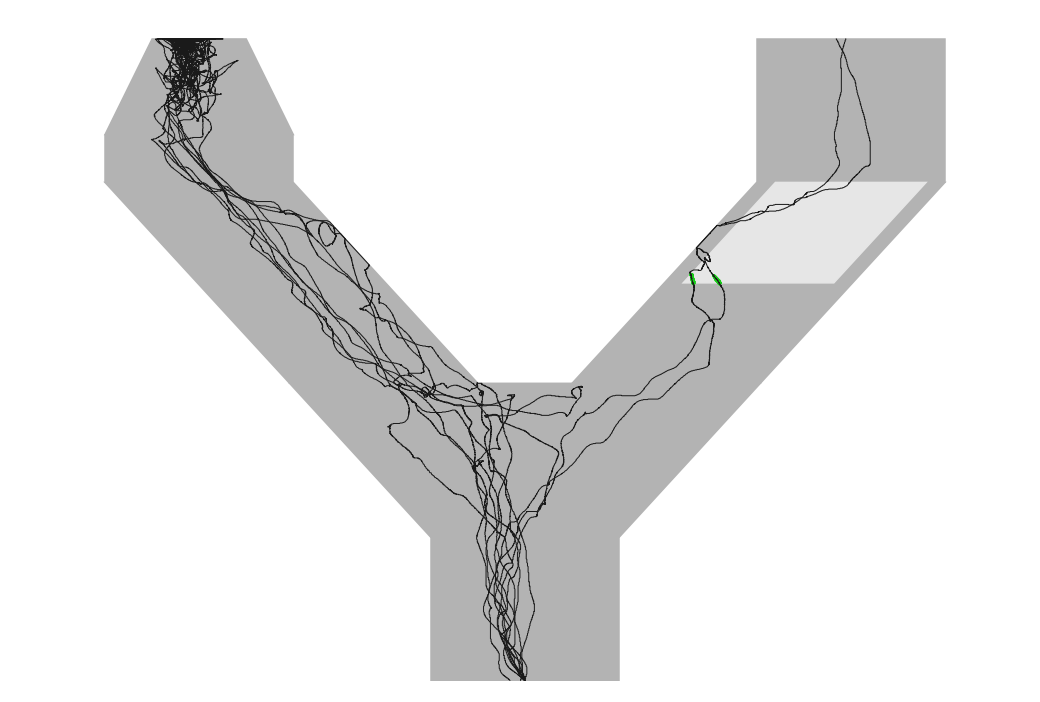

In [1179]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
mvr.draw(maze[Id],False)
#mvr.trace(session, keep, [0.1, 0.1, 0.1])
mvr.licks(session, keep, [0.9, 0.1, 0.1])
mvr.water(session, keep, [0.1, 0.8, 0.1])
mvr.trace(session,keep,[0.1, 0.1, 0.1])

In [1180]:
def pathlength(x,y,degree=3)  :
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: x(t) spline, y(t) spline, path length
    ''' 
    
    t = range(len(x)) #time series
    fx = interpolate.UnivariateSpline(t, x, k=degree)
    fy = interpolate.UnivariateSpline(t, y, k=degree)
    #print len(x),len(fx(t))
    x_coef = fx.get_coeffs()[~np.isnan(fx.get_coeffs())]
    y_coef = fy.get_coeffs()[~np.isnan(fy.get_coeffs())]
    
    dxdt = fx.derivative()
    dydt = fy.derivative()

    dx_array = [dxdt(xi) for xi in t]
    dy_array = [dydt(yi) for yi in t]

    dx2 = np.square(dx_array)
    dy2 = np.square(dy_array)

    hyp2 = np.add(dx2,dy2)
    integrand = np.sqrt(hyp2)

    length = sum(integrand)

    
    return fx, fy,length 

In [1181]:
def fitpath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & ~session.iti].values[:-100]
        yCord = session.yMazePos[(session.number == t) & ~session.iti].values[:-100] 
    
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 

In [1182]:
plen = fitpath(session,keep)
trial['Pathlengths'] = plen

In [1183]:
def choicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial :   
        xCord = session.xMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        yCord = session.yMazePos[(session.number == t) & (session.curBranchId == 1) & ~session.iti].values
        if len(xCord)==0:
            pathlengths.append('NaN')
            continue
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
choicelen = choicepath(session,keep)
trial['choicePath'] = choicelen
#trial


In [1184]:
def initchoicepath(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    pathlengths = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        if len(np.nonzero(inchoice)[1])==0:
            pathlengths.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        #print "enter 1 for trial"+str(t)+'='+str(enter1)
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        #print "exit 1 for trial"+str(t)+'='+str(exit1)
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
        #print len(xCord)
        pathlengths.append(pathlength(xCord,yCord)[2])
    
    return pathlengths 
initchoicelen = initchoicepath(session,keep)
trial['initChoicePath'] = initchoicelen

In [1185]:
#plt.hist(choicelen,50)
#plt.title('Choice Path')

#plt.figure()
#plt.hist(initchoicelen,50)
#plt.title('initChoice Path')

#plt.figure()
#plt.hist(plen,50)
#plt.title('Path Length')

In [1186]:
#plt.plot(choicelen)
#plt.title('Choice Path')

#plt.figure()
#plt.plot(initchoicelen)
#plt.title('initChoice Path')


#plt.figure()
#plt.plot(plen)
#plt.title('Path Length')

In [1187]:
#plt.hist(trial.time,50)
#plt.title('Total time')

#plt.figure()
#plt.hist(trial.timeChoice,50)
#plt.title('Choice time')

#plt.figure()
#plt.hist(trial.initChoiceTime,50)
#plt.title('Init choice time')

In [1188]:
#plt.plot(trial.time)
#plt.title('Total time')

#plt.figure()
#plt.plot(trial.timeChoice)
#plt.title('Choice time')

#plt.figure()
#plt.plot(trial.initChoiceTime)
#plt.title('Init choice time')

10
0
2


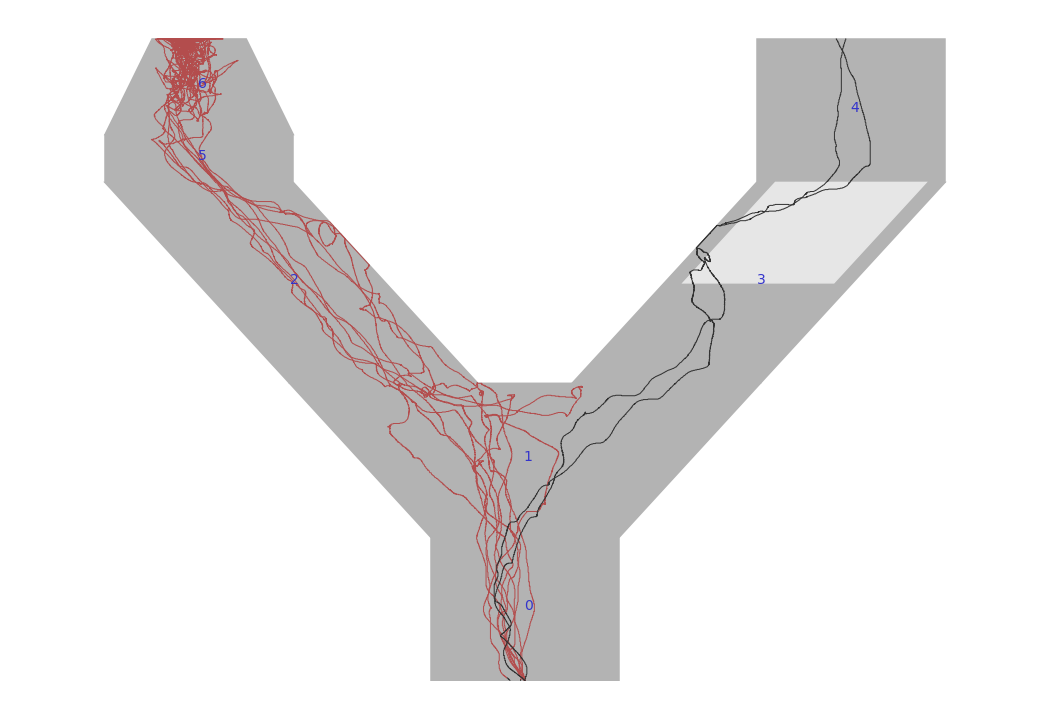

In [1189]:
#For the Anti-bias maze (left or right)

plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 5 #dead end regardless of maze
keepE = trialEntered(branchId)

if maze[0].get('name') == 'OneChoiceLcts.mat':
    branchId = 3 #antibias left
else:
    branchId = 2 #antibias right

keepW = trialEntered(branchId)


keepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepI)
mvr.trace(session, keepI, [0.7, 0.3, 0.3]) #incorrect
keepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keepS)
mvr.trace(session, keepS, [0.3, 0.7, 0.3]) #entered 3 but corrected itself
keepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keepC)
mvr.trace(session, keepC, [0.2, 0.2, 0.2]) #correct

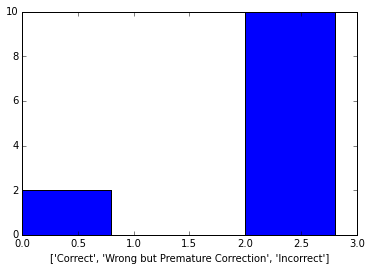

In [1190]:
classified = [len(keepC), len(keepS),len(keepI)]
numtrls = sum(classified)
plt.bar(range(0,len(classified)),classified)
plt.xlabel(['Correct', 'Wrong but Premature Correction', 'Incorrect'])

# Create dot plot

([<matplotlib.axis.YTick at 0x1184e80d0>,
 <a list of 2 Text yticklabel objects>)

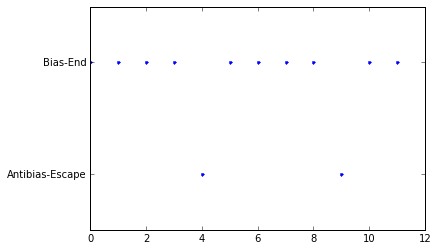

In [1191]:
plt.plot(trialEntered(6),'.')
plt.ylim((-0.5,1.5))
plt.yticks([0,1],['Antibias-Escape','Bias-End'])
#in which 1 = left and 0 = right

In [1192]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        if maze[0].get('name') == 'OneChoiceLcts.mat':
            if x in keepI:
                choices[x] = "R"
            elif x in keepS:
                choices[x] = "RL"
            else:
                choices[x] = "L"
        else: # ANTIBIAS RIGHT
            if x in keepI:
                choices[x] = "L"
            elif x in keepS:
                choices[x] = "LR"
            else:
                choices[x] = "R"
    return choices
choices = init_choice(numtrls)
trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 
#print trial

In [1193]:
def dead_end(numtrials):
    end = trialEntered(6)             
    return end

deadends = dead_end(numtrls)
trial['deadEnd'] = deadends
#print trial

In [1194]:
#Total bias split, based on initial choices

percent_correct = len(keepC)/float(numtrls)
percent_wrong = (len(keepS)+len(keepI))/float(numtrls)
percent_qswitch = len(keepS)/float(numtrls)

print percent_correct,percent_wrong, percent_qswitch

0.166666666667 0.833333333333 0.0


In [1195]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
#print len(complete)
#print numtrls
trial['Completed'] = complete

incomplete = complete.count(False)
percent_unfin = incomplete/float(len(complete))
print incomplete,percent_unfin


10 0.833333333333


In [1196]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times
#print trial

In [1197]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    dt = 0.002
    for n in range(numtrials):
        in1 = len(session[session.number==n].time[session.curBranchId==choicept])*dt
        in0 = len(session[session.number==n].time[session.curBranchId==entrance])*dt
        
        think.append(in1)
        straight.append(in0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeStraight'] = t_straight
trial['timeChoice'] = t_choosing

#print trial

In [1198]:
def initchoice_time(session,numtrials):
    dt = 0.002 #seconds per timestep
    initchoice_t = []
    for n in range(numtrials):
        inchoice = [(session.curBranchId==1) & (session.number==n)]
        if len(np.nonzero(inchoice)[1])==0:
            initchoice_t.append(0)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        inchoice = list(inchoice[0][enter1:])
        exit1 = enter1 + inchoice.index(0)
        initchoice_t.append((exit1-enter1)*dt)
    return initchoice_t

initchoice_t= initchoice_time(session,numtrls)
trial['initChoiceTime'] = initchoice_t
#trial    

In [1199]:
import math
def Idphi(x,y,degree=3):
    '''
    x and y arrays must have the same dimensions
    Implements arclength formula to estimate the total length of a fitted spline (cubic default)
    
    Returns: idphi
    ''' 
    
    t = range(len(x)) #time series
    dx_array = np.diff(x)
    dy_array = np.diff(y)
    d = range(len(dx_array))
    phi = [math.atan2(dy_array[i],dx_array[i]) for i in d]
    phi = np.unwrap(phi)
    phispline = interpolate.UnivariateSpline(range(len(phi)),phi, k=degree)
   
    dphispline = phispline.derivative()
    '''
    plt.plot(x,y)
    plt.xlim(0,70)
    plt.figure()
    plt.plot(phi)
    plt.plot(d,phispline(d))
    plt.figure()
    plt.plot(d,dphispline(d))
    '''
    
    dphi = [abs(i) for i in dphispline(d)]
    result = sum(dphi)
    
    return result
    
x = [10,10,10,10,20,30,40,50,60,60,60]
y = [0,10,20,30,30,30,30,30,30,50,60]

Idphi(x,y)  

4.6760788088834069

In [1200]:
def get_idphi(session,trial):
    if not isinstance(trial, (list, tuple)):
        trial = [trial]
    idphi = []    
    for t in trial : 
        inchoice = [(session.curBranchId==1) & (session.number==t)]
        
        if len(np.nonzero(inchoice)[1])==0:
            idphi.append(np.nan)
            continue
        enter1 = np.nonzero(inchoice)[1][0]
        
        inchoice = list(inchoice[0][enter1:])

        exit1 = enter1 + inchoice.index(0)
        
        exitbranch = session.curBranchId[(session.trialIndex==exit1)].values[0]
        
        if not (exitbranch ==2 or exitbranch==3):
            idphi.append(np.nan)
            continue 
        
        xCord = session.xMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values
        yCord = session.yMazePos[(session.trialIndex > enter1) & (session.trialIndex < exit1) & (session.number==t)].values 
       
        idphi.append(Idphi(xCord,yCord))
    return idphi

idphi = get_idphi(session,keep)
trial['IdPhi'] = idphi     

In [1201]:
zidphi = ((trial.IdPhi - trial.IdPhi.mean())/trial.IdPhi.std(ddof=0))
#print zidphi
trial['zIdPhi'] = zidphi

In [1202]:
newfolder = path+'/summary'

In [1203]:
#os.mkdir(newfolder)

In [1204]:
trial.to_csv(newfolder + '/trial_summary90.csv')